In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from ipywidgets import interact

In [2]:
images_setosa = np.array([np.array(Image.open("iris-setosa/"+image).resize((100,100))) for image in os.listdir("iris-setosa/")])

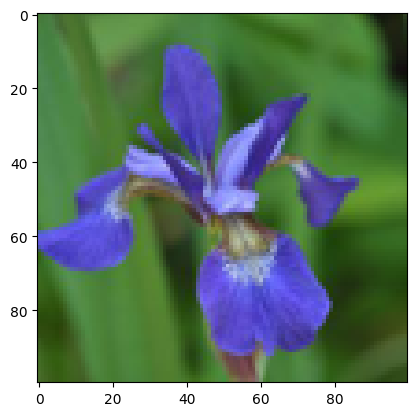

In [3]:
plt.imshow(images_setosa[0])
plt.show()

In [4]:
def pre_normalize(X):
    X=X/255 #pixels in [0,1]
    mu=X.mean(axis=0)
    std=X.std(axis=0)
    std_filled=std.copy()
    std_filled[std==0]=1 # such that dividing by 0 gives no error/NaN
    Xbar=(X-mu)/std
    return Xbar,mu,std

In [5]:
def eig(S):
    values,vectors=np.linalg.eig(S)
    ind=np.argsort(values)[::-1] #reverses order
    return values[ind], vectors[:,ind]  

In [6]:
def projection_matrix(B):
    return (B@np.linalg.inv(B.T@B)@B.T)

In [7]:
def PCA(X,num_components):
    N=X.shape[0]
    S=(X@X.T)/N
    values,vectors=eig(S)
    B=X.T@np.real(vectors[:,:num_components])
    pmatrix = projection_matrix(B.astype(np.float32))
    return (pmatrix@X.T).T

In [8]:
def mse(X,reconst):
    return np.square(X-reconst).sum(axis=1).mean()

In [9]:
N=images_setosa.shape[0]
Xbar,mu,std=pre_normalize(images_setosa.reshape(N,100*100*3))

In [12]:
loss=list()
reconst=list()
for npc in range(1,67, 5):
    Xtilde=PCA(Xbar, npc)
    loss.append([mse(Xbar,Xtilde),npc])
    Xtilde_unnorm=(Xtilde*std+mu).reshape(N,100,100,3)
    Xbar_unnorm=(Xbar*std+mu).reshape(N,100,100,3)
    reconst.append(np.concatenate((Xbar_unnorm,Xtilde_unnorm),axis=2))
    

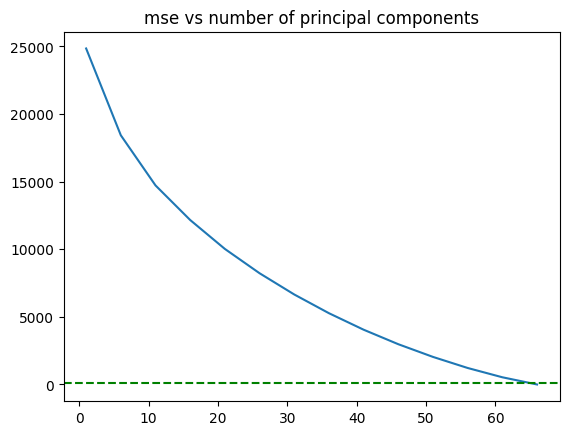

In [13]:
values=np.array(loss)
plt.plot(values[:,1],values[:,0])
plt.axhline(100, linestyle='--', color='g',)
plt.title("mse vs number of principal components")
plt.xlabel="num components"
plt.ylable="mse"
plt.show()

In [30]:
%matplotlib widget
@interact(i=(0, 13))
def img_vs_construct(i=12):
    plt.figure(figsize=(4,4))
    image=reconst[i][0]
    print("Number of Principal Components: "+str(values[:,1][i]))
    plt.imshow( np.clip(image, 0, 1))
    plt.show()

interactive(children=(IntSlider(value=12, description='i', max=13), Output()), _dom_classes=('widget-interact'…